In [1]:
# Test the ability of a model trained on Dataset 1 to generalize to Dataset 2
# Negative class (0) Non-cyberbullying/Non-hatespeech
# Positive class (1) Cyberbullying/Hatespeech

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from catboost import Pool
from pathlib import Path
import json
import random
import sys
sys.path.append('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\src')
from utils.results import create_results_file, append_results_to_json
from utils.data import balance_train_and_test, get_OOV_feats
from catboost import CatBoostClassifier


In [3]:
RANDOM_SEED = 115
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
CLEAN_DATA_PATH = Path("../data/en_only")
EXPERIMENTS_PATH = Path('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\experiments')
RESULT_PATH = Path('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\experiments\\results\\exp3')

In [5]:
TRAIN_DATA_NAME = '48000_cyberbullying_tweets_basic_clean.csv' 
TEST_DATA_NAME = 'hatespeech_tweets_basic_clean.csv'

In [6]:
train_data = CLEAN_DATA_PATH / TRAIN_DATA_NAME
test_data = CLEAN_DATA_PATH / TEST_DATA_NAME

### Test 1 
- Consider offensive tweets to be bullying tweets

In [31]:
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

test_df.rename(columns={'class': 'label'}, inplace=True)  # Rename 'class' to 'label'

In [32]:
train_df.dropna(axis=0, inplace=True)
train_df.drop_duplicates(inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df['label'].value_counts()

label
religion     7942
age          7910
gender       7396
ethnicity    7319
other        6731
notcb        6377
Name: count, dtype: int64

In [33]:
test_df.dropna(axis=0, inplace=True)
test_df.drop_duplicates(inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df['label'].value_counts()

label
1    17476
2     3786
0     1246
Name: count, dtype: int64

In [34]:
# Drop hate speech tweets from test_df
test_df = test_df[test_df["label"] != 0]
print(f'Test DF: {test_df["label"].value_counts()}')

Test DF: label
1    17476
2     3786
0     1246
Name: count, dtype: int64

Test DF: label
1    17476
2     3786
Name: count, dtype: int64


In [37]:
# Encode the labels of the train and test datasets with numbers.
# The Offensive tweets of Dataset will be classified as CB and the Hate Speech will be ignored.
train_df['label'] = train_df['label'].apply(lambda label : 0 if label == 'notcb' else 1)
test_df['label'] = test_df['label'].map({0:2, 1:1, 2:0}) 

label2id = {'notcb': 0, 'cb': 1}
id2label = {0: 'notcb', 1: 'cb'}

print(train_df.shape[0])
print(test_df.shape[0])

In [54]:
# balance the datasets
notcb_train, cb_train = train_df[train_df['label'] == 0], train_df[train_df['label'] == 1]
notcb_test, cb_test = test_df[test_df['label'] == 0], test_df[test_df['label'] == 1]
tr_df, te_df, num_to_move, ratio = balance_train_and_test(notcb_train, cb_train, notcb_test, cb_test, random_state=RANDOM_SEED)
print(f'Ratio of negative to positive: {ratio:.4f}')

In [9]:
import json

# Define the path to the JSON file
json_file_path = EXPERIMENTS_PATH / 'hyps/exp3/exp3_hyp_search_top25_xgb_results.json'

# Read the JSON file
with open(json_file_path, 'r') as file:
    params_dict = json.load(file)['params']

In [12]:
for _, params in params_dict.items():
    print(params)


{'classifier__booster': 'gbtree', 'classifier__colsample_bynode': 0.5127750630060814, 'classifier__colsample_bytree': 0.8143277530971073, 'classifier__gamma': 0.20680212411155285, 'classifier__learning_rate': 0.23559045261016354, 'classifier__max_depth': 6, 'classifier__min_child_weight': 0.5819851460227308, 'classifier__n_estimators': 256, 'classifier__random_state': 7012, 'classifier__reg_alpha': 0.9914660637279762, 'classifier__reg_lambda': 0.006092935307123924, 'classifier__scale_pos_weight': 0.6694998977474443, 'classifier__subsample': 0.8556825366317966, 'vectorizer': 'TfidfVectorizer', 'vectorizer__analyzer': 'word', 'vectorizer__max_df': 0.7039640994503941, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': [1, 2], 'vectorizer__preprocessor': 'pp_LancasterStemmer'}
{'classifier__booster': 'gbtree', 'classifier__colsample_bynode': 0.5640574966320087, 'classifier__colsample_bytree': 0.5522653762921521, 'classifier__gamma': 0.7277182103077888, 'classifier__learning_rate': 0.19544

In [ ]:
from sklearn.pipeline import Pipeline

for _, params in params_dict.items():

    vectorizer: CountVectorizer | TfidfVectorizer = get_vectorizer_class(params)
    vect_params = get_vect_params(params)

    classifier_params = get_classifier_params(params)
    classifier_fit_params = get_classifier_fit_params(params)

    pipeline = Pipeline([
        ('vectorizer', vectorizer(**vect_params)),
        ('classifier', CatBoostClassifier(**classifier_params))
    ])

    pipeline.fit(tr_df['tweet'], tr_df['label'])
    preds = pipeline.predict(te_df['tweet'])
    result = {}
    print(report:=classification_report(te_df['label'], preds, target_names=['notcb', 'cb']))
    result['classification_report'] = report
    result['model_name'] = 'CatBoostClassifier'
    result['model_params'] = {k: str(v) if isinstance(v, type) else v for k, v in pipeline.named_steps['classifier'].get_all_params().items()}
    result['vectorizer'] = vectorizer.__class__.__name__
    result['vectorizer_params'] = {k: str(v) if isinstance(v, type) else v for k, v in vect_params.items()}
    append_results_to_json(result, RESULT_PATH / 'exp3_1.json')
    

In [146]:
import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer, LancasterStemmer, PorterStemmer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = LancasterStemmer()
pp = lambda x: ' '.join([lemmatizer.stem(word.lower()) for word in x.split()])
vect = CountVectorizer(preprocessor=pp)
vect.fit(tr_df['tweet'])
x_train = vect.transform(tr_df['tweet'])
x_test = vect.transform(te_df['tweet'])
y_train = tr_df['label']
y_test = te_df['label']

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rooty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rooty\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [147]:
# Calculate the number of out-of-vocabulary (OOV) features
vect2 = CountVectorizer(preprocessor=pp)
vect2.fit(te_df['tweet'])
feats_train = vect.get_feature_names_out()
feats_test = vect2.get_feature_names_out()
oov_feats = np.setdiff1d(feats_test, feats_train)
num_oov_feats = len(oov_feats)
print(f"Number of OOV features: {num_oov_feats}")

Number of OOV features: 6016


              precision    recall  f1-score   support

       notcb       0.80      0.38      0.51      3243
          cb       0.89      0.98      0.94     17476

    accuracy                           0.89     20719
   macro avg       0.85      0.68      0.72     20719
weighted avg       0.88      0.89      0.87     20719



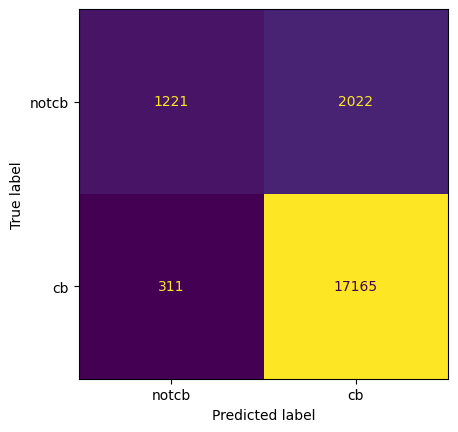

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


xgboost_model = RandomForestClassifier(random_state=RANDOM_SEED)
xgboost_model.fit(x_train, y_train)
preds = xgboost_model.predict(x_test)
print(classification_report(y_test, preds, target_names=['notcb', 'cb']))
ConfusionMatrixDisplay.from_estimator(xgboost_model, x_test, y_test, display_labels=['notcb', 'cb'], colorbar=False)

In [100]:
len(vect.vocabulary_)

46197

In [25]:
ratio = (tr_df['label'] == 0).sum() / (tr_df['label'] == 1).sum()
create_results_file(RESULT_PATH / 'exp3_1.json')

for vect in [CountVectorizer(), CountVectorizer(ngram_range=(1,2)), TfidfVectorizer(), TfidfVectorizer(ngram_range=(1,2))]:
    x_train, y_train = tr_df['tweet'], tr_df['label']
    x_test, y_test = te_df['tweet'], te_df['label']

    x_train = vect.fit_transform(x_train)
    # calculate the number of OOV features
    vect2 = CountVectorizer()
    vect2.fit(x_test)
    feats_train = vect.get_feature_names_out()
    feats_test = vect2.get_feature_names_out()
    oov_feats = np.setdiff1d(feats_test, feats_train)
    x_test = vect.transform(x_test)

    m = xgb.XGBClassifier(random_state=RANDOM_SEED, scale_pos_weight=ratio)
    m.fit(x_train, y_train)
    y_pred = m.predict(x_test)
    result = classification_report(y_test, y_pred, output_dict=True)
    result['num_OOV_feats'] = len(oov_feats)
    result['neg_to_pos_ratio'] = ratio
    result['model_name'] = 'XGBClassifier'
    result['model_params'] = {k: str(v) if isinstance(v, type) else v for k, v in m.get_params().items()}
    result['vectorizer'] = vect.__class__.__name__
    result['vectorizer_params'] = {k: str(v) if isinstance(v, type) else v for k, v in vect.get_params().items()}
    append_results_to_json(result, RESULT_PATH / 'exp3_1.json')

Results file already exists. Not creating new one


In [27]:
ratio = (train_df['label'] == 0).sum() / (train_df['label'] == 1).sum()
create_results_file(RESULT_PATH / 'exp3_1.json')

for vect in [CountVectorizer(), CountVectorizer(ngram_range=(1,2)), TfidfVectorizer(), TfidfVectorizer(ngram_range=(1,2))]:
    x_train, y_train = tr_df['tweet'], tr_df['label']
    x_test, y_test = te_df['tweet'], te_df['label']

    x_train = vect.fit_transform(x_train)
    # calculate the number of OOV features
    vect2 = CountVectorizer()
    vect2.fit(x_test)
    feats_train = vect.get_feature_names_out()
    feats_test = vect2.get_feature_names_out()
    oov_feats = np.setdiff1d(feats_test, feats_train)
    x_test = vect.transform(x_test)

    train_pool = Pool(x_train, y_train)
    test_pool = Pool(x_test, y_test)

    m = CatBoostClassifier(random_state=RANDOM_SEED, class_weights=[1,ratio])
    m.fit(train_pool)
    y_pred = m.predict(test_pool)
    result = classification_report(y_test, y_pred, output_dict=True)
    result['num_OOV_feats'] = len(oov_feats)
    result['neg_to_pos_ratio'] = ratio
    result['model_name'] = 'CatBoostClassifier'
    result['model_params'] = {k: str(v) if isinstance(v, type) else v for k, v in m.get_all_params().items()}
    result['vectorizer'] = vect.__class__.__name__
    result['vectorizer_params'] = {k: str(v) if isinstance(v, type) else v for k, v in vect.get_params().items()}
    append_results_to_json(result, RESULT_PATH / 'exp3_1.json')

Results file already exists. Not creating new one
Learning rate set to 0.051952
0:	learn: 0.6689237	total: 211ms	remaining: 3m 30s
1:	learn: 0.6484649	total: 285ms	remaining: 2m 22s
2:	learn: 0.6296581	total: 359ms	remaining: 1m 59s
3:	learn: 0.6155803	total: 433ms	remaining: 1m 47s
4:	learn: 0.6000448	total: 508ms	remaining: 1m 41s
5:	learn: 0.5881270	total: 581ms	remaining: 1m 36s
6:	learn: 0.5774675	total: 655ms	remaining: 1m 32s
7:	learn: 0.5664402	total: 732ms	remaining: 1m 30s
8:	learn: 0.5570753	total: 805ms	remaining: 1m 28s
9:	learn: 0.5494479	total: 879ms	remaining: 1m 27s
10:	learn: 0.5429892	total: 953ms	remaining: 1m 25s
11:	learn: 0.5363559	total: 1.02s	remaining: 1m 24s
12:	learn: 0.5303999	total: 1.1s	remaining: 1m 23s
13:	learn: 0.5241900	total: 1.17s	remaining: 1m 22s
14:	learn: 0.5187571	total: 1.25s	remaining: 1m 21s
15:	learn: 0.5130850	total: 1.32s	remaining: 1m 21s
16:	learn: 0.5079669	total: 1.4s	remaining: 1m 20s
17:	learn: 0.5005842	total: 1.47s	remaining: 1m 

In [83]:
preds = m.predict(x_test)
print(classification_report(y_test, preds, target_names=['notcb', 'cb']))

              precision    recall  f1-score   support

       notcb       0.34      0.94      0.50      3786
          cb       0.98      0.61      0.75     17476

    accuracy                           0.67     21262
   macro avg       0.66      0.77      0.63     21262
weighted avg       0.86      0.67      0.71     21262



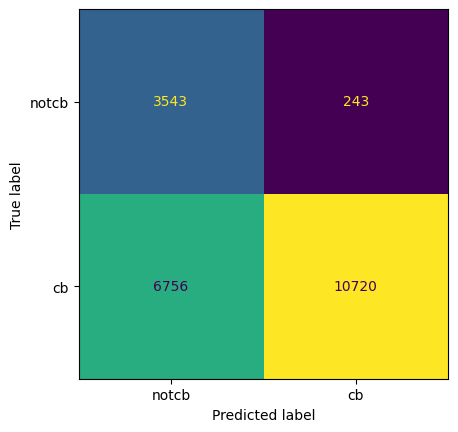

In [85]:
ConfusionMatrixDisplay.from_estimator(m, x_test, y_test, display_labels=['notcb', 'cb'], colorbar=False)

In [86]:
m = CatBoostClassifier(random_state=RANDOM_SEED, logging_level='Silent', class_weights=[1, ratio])
m.fit(x_train, y_train)

In [ ]:
preds = m.predict(x_test)

### Test 2
- Consider hate speech to be bullying tweets

In [8]:
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

# remove duplicates
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()
# remove rows with missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

test_df.rename(columns={'class': 'label'}, inplace=True)  # Rename 'class' to 'label'

In [9]:
# add offensive rows and neither rows to the train_df
# Add offensive rows to the train_df
test_df['label'] = test_df['label'].apply(lambda label : 1 if label == 0 else 0)

notcb_test = test_df[test_df['label'] == 0]
cb_test = test_df[test_df['label'] == 1]

In [10]:
# Relabel train_df with 1 for cyberbullying and 0 for notcb
train_df['label'] = train_df['label'].apply(lambda label : 0 if label == 'notcb' else 1)

notcb_train = train_df[train_df['label'] == 0]
cb_train = train_df[train_df['label'] == 1]

In [11]:
print(notcb_test.shape[0])
print(notcb_train.shape[0])
print(cb_test.shape[0])
print(cb_train.shape[0])

21262
6377
1246
37298


In [12]:

tr_df, te_df, num_moved, ratio = balance_train_and_test(notcb_train, cb_train, notcb_test, cb_test, random_state=RANDOM_SEED)

In [24]:
te_df['label'].value_counts()

label
1    1246
0     894
Name: count, dtype: int64

In [13]:
print(f'Train DF:\n{train_df["label"].value_counts()} \n')
print(f"Test DF:\n{test_df['label'].value_counts()}")

Train DF:
label
1    37298
0     6377
Name: count, dtype: int64 

Test DF:
label
0    21262
1     1246
Name: count, dtype: int64


In [20]:
create_results_file(RESULT_PATH / 'exp3_2.json')
oov_feats = get_OOV_feats(tr_df['tweet'], te_df['tweet'], print_oov_feats=False)
print(f'Num of OOV feats: {len(oov_feats)}')

Results file already exists. Not creating new one


In [21]:
VECTS = [
    CountVectorizer(),
    TfidfVectorizer(),
    CountVectorizer(ngram_range=(1, 2)),
    TfidfVectorizer(ngram_range=(1, 2)),
]

for vect in VECTS:
    x_train, y_train = tr_df['tweet'], tr_df['label']
    x_test, y_test = te_df['tweet'], te_df['label']

    x_train = vect.fit_transform(x_train)
    x_test = vect.transform(x_test)

    m = xgb.XGBClassifier(verbosity=0, random_state=RANDOM_SEED, scale_pos_weight=ratio)
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    print(result:=classification_report(y_test, preds, target_names=['cb', 'notcb'], output_dict=True))
    result['num_OOV_feats'] = len(oov_feats)
    result['neg_to_pos_ratio'] = ratio
    result['model_name'] = "XGBClassifier"
    result['model_params'] = {k: str(v) if isinstance(v, type) else v for k, v in m.get_params().items()}
    result['vectorizer'] = vect.__class__.__name__
    result['vectorizer_params'] = {k: str(v) if isinstance(v, type) else v for k, v in vect.get_params().items()}
    append_results_to_json(result, RESULT_PATH / 'exp3_2.json')


{'cb': {'precision': 0.43336623889437315, 'recall': 0.9821029082774049, 'f1-score': 0.6013698630136987, 'support': 894.0}, 'notcb': {'precision': 0.8596491228070176, 'recall': 0.07865168539325842, 'f1-score': 0.14411764705882352, 'support': 1246.0}, 'accuracy': 0.45607476635514016, 'macro avg': {'precision': 0.6465076808506953, 'recall': 0.5303772968353316, 'f1-score': 0.3727437550362611, 'support': 2140.0}, 'weighted avg': {'precision': 0.6815664600883707, 'recall': 0.45607476635514016, 'f1-score': 0.33513796531286943, 'support': 2140.0}}
{'cb': {'precision': 0.4310850439882698, 'recall': 0.9865771812080537, 'f1-score': 0.6, 'support': 894.0}, 'notcb': {'precision': 0.8723404255319149, 'recall': 0.06581059390048154, 'f1-score': 0.12238805970149254, 'support': 1246.0}, 'accuracy': 0.4504672897196262, 'macro avg': {'precision': 0.6517127347600924, 'recall': 0.5261938875542677, 'f1-score': 0.3611940298507463, 'support': 2140.0}, 'weighted avg': {'precision': 0.6880028969805042, 'recall':

In [26]:
VECTS = [
    CountVectorizer(),
    TfidfVectorizer(),
    CountVectorizer(ngram_range=(1, 2)),
    TfidfVectorizer(ngram_range=(1, 2)),
]

for vect in VECTS:
    x_train, y_train = tr_df['tweet'], tr_df['label']
    x_test, y_test = te_df['tweet'], te_df['label']

    x_train = vect.fit_transform(x_train)
    x_test = vect.transform(x_test)

    train_pool = Pool(x_train, y_train)
    test_pool = Pool(x_test, y_test)

    m = CatBoostClassifier(random_state=RANDOM_SEED, logging_level='Silent', class_weights=[1, ratio])
    m.fit(train_pool)
    preds = m.predict(test_pool)
    print(result:=classification_report(y_test, preds, target_names=['cb', 'notcb'], output_dict=True))
    result['model_name'] = "CatBoostClassifier"
    result['model_params'] = {k: str(v) if isinstance(v, type) else v for k, v in m.get_all_params().items()}
    result['vectorizer_name'] = vect.__class__.__name__
    result['vectorizer_params'] = {k: str(v) if isinstance(v, type) else v for k, v in vect.get_params().items()}
    append_results_to_json(result, RESULT_PATH / 'exp3_2.json')

{'cb': {'precision': 0.44114688128772633, 'recall': 0.9809843400447428, 'f1-score': 0.6086051353226926, 'support': 894.0}, 'notcb': {'precision': 0.8881578947368421, 'recall': 0.10834670947030497, 'f1-score': 0.19313304721030042, 'support': 1246.0}, 'accuracy': 0.47289719626168225, 'macro avg': {'precision': 0.6646523880122842, 'recall': 0.5446655247575238, 'f1-score': 0.4008690912664965, 'support': 2140.0}, 'weighted avg': {'precision': 0.7014159106137068, 'recall': 0.47289719626168225, 'f1-score': 0.3666994242067857, 'support': 2140.0}}
{'cb': {'precision': 0.43579573624194345, 'recall': 0.9832214765100671, 'f1-score': 0.6039161800068705, 'support': 894.0}, 'notcb': {'precision': 0.8780487804878049, 'recall': 0.08667736757624397, 'f1-score': 0.15777940102264426, 'support': 1246.0}, 'accuracy': 0.461214953271028, 'macro avg': {'precision': 0.6569222583648742, 'recall': 0.5349494220431555, 'f1-score': 0.38084779051475737, 'support': 2140.0}, 'weighted avg': {'precision': 0.693294471349

NameError: name 'RESULT_PATH' is not defined